In [1]:
import joblib

In [43]:
data_path = "/home/jianrenw/mocap/data/actioncore/action_core.pt"
adam_poses = joblib.load(data_path)

In [44]:
# key = "KIT_3_walking_medium02_poses"
key = "billiejean_dance01"
adam_pose = adam_poses[key]

In [2]:
data_path = "/home/jianrenw/MAP/data/isaac_adam_standard_add_sign.pt"
adam_poses = joblib.load(data_path)

In [4]:
from isaacgym import gymapi, gymtorch, gymutil

Importing module 'gym_38' (/home/jianrenw/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/jianrenw/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/home/jianrenw/anaconda3/envs/MAP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 1.13.1
Device count 4
/home/jianrenw/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/jianrenw/.cache/torch_extensions/py38_cu116 as PyTorch extensions root...
Emitting ninja build file /home/jianrenw/.cache/torch_extensions/py38_cu116/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


In [5]:
gym = gymapi.acquire_gym()

sim = gym.create_sim()

# add cartpole urdf asset
asset_root = "robots/adam_standard"
asset_file = "urdf/adam_standard_foot_contact.urdf"

asset_options = gymapi.AssetOptions()
asset_options.collapse_fixed_joints = False

robot_asset = gym.load_asset(sim, asset_root, asset_file)
rigid_body_names = gym.get_asset_rigid_body_names(robot_asset)
rigid_body_dict = gym.get_asset_rigid_body_dict(robot_asset)
dof_names = gym.get_asset_dof_names(robot_asset)
left_ankle_idx = rigid_body_names.index("toeLeft")
right_ankle_idx = rigid_body_names.index("toeRight")
left_foot_indices = [i for i, name in enumerate(rigid_body_names) if 'leftFoot' in name]
right_foot_indices = [i for i, name in enumerate(rigid_body_names) if 'rightFoot' in name]

Physics Engine: FleX
Physics Device: cuda:0
GPU Pipeline: disabled


In [6]:
import numpy as np
import torch

In [7]:
spacing = 2.0
lower = gymapi.Vec3(-spacing, -spacing, -spacing)
upper = gymapi.Vec3(spacing, spacing, spacing)
env = gym.create_env(sim, lower, upper, 1)

pose = gymapi.Transform()
pose.p = gymapi.Vec3(0.0, 0.0, 2.0)

actor_handle = gym.create_actor(env, robot_asset, pose, "adam_actor", 0, 1)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
keys = adam_poses.keys()
jumps = []
for k in keys:
    if 'hop' in k:
        jumps.append(k)

In [24]:
jumps

['ACCAD_Male2Walking_c3d_B17 -  Walk to hop to walk a_poses',
 'ACCAD_Male2Walking_c3d_B17 -  Walk to hop to walk_poses',
 'ACCAD_Female1Walking_c3d_B17 - walk to hop to walk1_poses',
 'ACCAD_Male2Running_c3d_C18 - run to hop to walk_poses',
 'ACCAD_Male1Walking_c3d_Walk B17 - Walk 2 hop 2 walk_poses',
 'ACCAD_Female1Running_c3d_C19 -  run to hop to walk_poses',
 'DFaust_67_50027_50027_light_hopping_loose_poses',
 'DFaust_67_50027_50027_light_hopping_stiff_poses',
 'DFaust_67_50025_50025_light_hopping_stiff_poses',
 'DFaust_67_50025_50025_light_hopping_loose_poses',
 'DFaust_67_50022_50022_light_hopping_stiff_poses',
 'DFaust_67_50022_50022_light_hopping_loose_poses',
 'DFaust_67_50002_50002_light_hopping_stiff_poses',
 'DFaust_67_50002_50002_light_hopping_loose_poses',
 'DFaust_67_50026_50026_light_hopping_stiff_poses',
 'DFaust_67_50026_50026_light_hopping_loose_poses',
 'DFaust_67_50004_50004_light_hopping_loose_poses',
 'DFaust_67_50004_50004_light_hopping_stiff_poses',
 'DFaust_67

In [3]:
# key = "KIT_3_walking_medium02_poses"
key = "ACCAD_Male2Walking_c3d_B17 -  Walk to hop to walk a_poses"
adam_pose = adam_poses[key]

KeyError: 'ACCAD_Male2Walking_c3d_B17 -  Walk to hop to walk a_poses'

In [69]:
root_pos = adam_pose["root_pos"]
root_rot = adam_pose["root_rot"]
root_vel = adam_pose["root_vel"]
root_angular_vel = adam_pose["root_angular_vel"]
dof_pos = adam_pose["dof_pos"]
dof_vel = adam_pose["dof_vel"]

frame_num = len(root_pos)

root_states = torch.cat([torch.from_numpy(root_pos), torch.from_numpy(root_rot), torch.from_numpy(root_vel), torch.from_numpy(root_angular_vel)], dim=1).type(torch.float32)
dof_states = torch.stack([torch.from_numpy(dof_pos), torch.from_numpy(dof_vel)],axis=2).type(torch.float32)
rigid_body_states = []

# Simulate
left_ankle_poses = []
right_ankle_poses = []

for i in range(frame_num):

    gym.set_actor_root_state_tensor(sim, gymtorch.unwrap_tensor(root_states[i]))
    gym.set_dof_state_tensor(sim, gymtorch.unwrap_tensor(dof_states[i]))
    gym.refresh_rigid_body_state_tensor(sim)
    rigid_body_state = gym.acquire_rigid_body_state_tensor(sim)
    rigid_body_state = gymtorch.wrap_tensor(rigid_body_state)
    left_foot_poses = rigid_body_state[left_foot_indices, 0:3]
    right_foot_poses = rigid_body_state[right_foot_indices, 0:3]
    new_rigid_body_state = rigid_body_state.clone()
    new_rigid_body_state[:,2] = new_rigid_body_state[:,2] - torch.min(torch.cat([left_foot_poses, right_foot_poses])[:,2])

    left_ankle_pose = new_rigid_body_state[left_ankle_idx, 0:3]
    right_ankle_pose = new_rigid_body_state[right_ankle_idx, 0:3]
    left_ankle_poses.append(left_ankle_pose.clone())
    right_ankle_poses.append(right_ankle_pose.clone())


In [48]:
# root_pos = adam_pose["root_pos"]
# root_rot = adam_pose["root_rot"]
# root_vel = adam_pose["root_vel"]
# root_angular_vel = adam_pose["root_angular_vel"]
# dof_pos = adam_pose["dof_pos"]
# dof_vel = adam_pose["dof_vel"]

# frame_num = len(root_pos)

# root_states = torch.cat([torch.from_numpy(root_pos), torch.from_numpy(root_rot), torch.from_numpy(root_vel), torch.from_numpy(root_angular_vel)], dim=1).type(torch.float32)
# dof_states = torch.stack([torch.from_numpy(dof_pos), torch.from_numpy(dof_vel)],axis=2).type(torch.float32)
# rigid_body_states = []

# # Simulate
# left_ankle_poses = []
# right_ankle_poses = []

# for i in range(frame_num):

#     gym.set_actor_root_state_tensor(sim, gymtorch.unwrap_tensor(root_states[i]))
#     gym.set_dof_state_tensor(sim, gymtorch.unwrap_tensor(dof_states[i]))
#     gym.refresh_rigid_body_state_tensor(sim)
#     rigid_body_state = gym.acquire_rigid_body_state_tensor(sim)
#     rigid_body_state = gymtorch.wrap_tensor(rigid_body_state)
#     left_foot_poses = rigid_body_state[left_foot_indices, 0:3]
#     right_foot_poses = rigid_body_state[right_foot_indices, 0:3]
#     left_ankle_pose = rigid_body_state[left_ankle_idx, 0:3]
#     right_ankle_pose = rigid_body_state[right_ankle_idx, 0:3]
#     new_root_pose = root_states[i, 0:3]
#     new_root_pose[2] = root_states[i, 2] - torch.min(torch.cat([left_foot_poses, right_foot_poses])[:,2])
#     left_ankle_poses.append(left_ankle_pose.clone())
#     right_ankle_poses.append(right_ankle_pose.clone())
    
    
    
#     new_root_poses.append(new_root_pose)
#     print(torch.min(torch.cat([left_foot_poses, right_foot_poses])[:,2]))
# new_root_poses = torch.stack(new_root_poses, dim=0)

In [70]:
left_ankle_poses = torch.stack(left_ankle_poses).numpy()
right_ankle_poses = torch.stack(right_ankle_poses).numpy()
left_z = left_ankle_poses[:,2]
right_z = right_ankle_poses[:,2]

In [72]:
right_z

array([0.07130735, 0.07130733, 0.07130668, 0.07130608, 0.07130501,
       0.07128504, 0.07126512, 0.07124441, 0.07120313, 0.07116186,
       0.07110786, 0.07105264, 0.07101472, 0.07097602, 0.07093678,
       0.07096872, 0.07100169, 0.07103451, 0.07113631, 0.07123822,
       0.0712827 , 0.07132518, 0.07136581, 0.07138909, 0.07140939,
       0.07140474, 0.07137696, 0.07161763, 0.07185254, 0.07208531,
       0.07280084, 0.07347046, 0.07408556, 0.07472417, 0.07445054,
       0.07405215, 0.07387823, 0.07677528, 0.07367025, 0.07373058,
       0.07450829, 0.07497974, 0.07521689, 0.07538054, 0.07544842,
       0.0757293 , 0.07601804, 0.07631236, 0.07648265, 0.07665437,
       0.07668509, 0.07670563, 0.07671243, 0.07664255, 0.07650011,
       0.07622232, 0.07572655, 0.07539139, 0.07641834, 0.08355847,
       0.08801513, 0.09351566, 0.09933534, 0.10046674, 0.10147862,
       0.0988168 , 0.09638018, 0.09625906, 0.09276937, 0.08927806,
       0.0889523 , 0.08867531, 0.08857922, 0.08848986, 0.08840

In [66]:
def find_flat_segments(arr, threshold=0.004, min_length=10):
    segments = []
    start = 0
    
    for i in range(1, len(arr)):
        if abs(arr[i] - arr[i-1]) >= threshold:
            if i - start >= min_length:
                segments.append((start, i-1))
            start = i
    
    # Check the last segment
    if len(arr) - start >= min_length:
        segments.append((start, len(arr)-1))
    
    flat_positions = []
    for flat_segment in segments:
        start_idx, end_idx = flat_segment
        flat_positions.append(np.arange(start_idx, end_idx))

    flat_positions = np.concatenate(flat_positions)
        

    return flat_positions

In [67]:
left_flat_positions = find_flat_segments(left_z)
right_flat_positions = find_flat_segments(right_z)

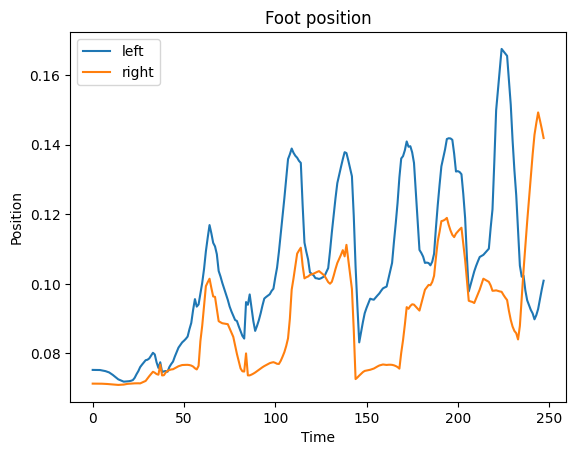

In [73]:
# mean_left_z = np.mean(left_z[left_flat_positions])
# corrected_left_z = left_z - mean_left_z 


# mean_right_z = np.mean(right_z[right_flat_positions])
# corrected_right_z = right_z - mean_right_z 

x = np.arange(0, len(left_z))
# plt.plot(x, corrected_left_z, label='left')
# plt.plot(x, corrected_right_z, label='right')
plt.plot(x, left_z, label='left')
plt.plot(x, right_z, label='right')
# plt.plot(x[left_flat_positions], left_z[left_flat_positions], 'ro')
# plt.plot(x[right_flat_positions], right_z[right_flat_positions], 'ro')


plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Foot position')
plt.legend()

plt.show()

In [74]:
np.amax(left_z)

0.16756934

In [33]:
left_ankle_poses

array([[0.19800745, 0.03108837, 0.07170925],
       [0.19810823, 0.03116776, 0.07167822],
       [0.19818991, 0.03128619, 0.07164761],
       [0.19821778, 0.03134955, 0.0716117 ],
       [0.19839345, 0.03152194, 0.07158688],
       [0.19857185, 0.03169462, 0.07156211],
       [0.19930437, 0.03211343, 0.07156187],
       [0.19975214, 0.03245576, 0.07153794],
       [0.20019746, 0.03314407, 0.07151484],
       [0.20062193, 0.0338073 , 0.07148051],
       [0.20080729, 0.03442634, 0.07142115],
       [0.20112208, 0.03523651, 0.07134897],
       [0.2014024 , 0.03582089, 0.07126161],
       [0.20164439, 0.03637509, 0.07115388],
       [0.2017792 , 0.03697287, 0.07102588],
       [0.20242879, 0.03770528, 0.07090601],
       [0.20276049, 0.03803869, 0.07075366],
       [0.20331961, 0.03880226, 0.07060054],
       [0.20391457, 0.03918292, 0.07043856],
       [0.20481662, 0.03979699, 0.07027403],
       [0.20550697, 0.04007382, 0.07009235],
       [0.20646141, 0.04053346, 0.06990451],
       [0.

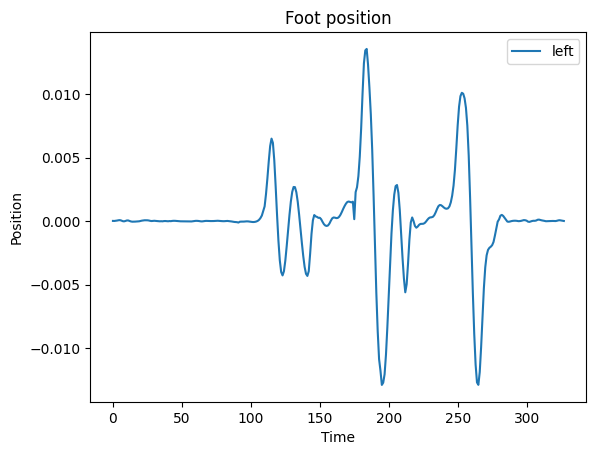

In [426]:
x = np.arange(0, len(right_z) -1)
# plt.plot(x, corrected_left_z, label='left')
# plt.plot(x, corrected_right_z, label='right')
plt.plot(x, np.diff(right_z), label='left')

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Foot position')
plt.legend()

plt.show()

In [427]:
mean_left_z

0.078058116

In [31]:
threshold = 0.004

left_food_contact = np.zeros_like(left_z)
right_food_contact = np.zeros_like(right_z)

diff = corrected_left_z - corrected_right_z
left_food_contact[np.abs(diff) < threshold] = 1
right_food_contact[np.abs(diff) < threshold] = 1

left_food_contact[diff >= threshold] = 0
right_food_contact[diff >= threshold] = 1

left_food_contact[diff <= -threshold] = 1
right_food_contact[diff <= -threshold] = 0

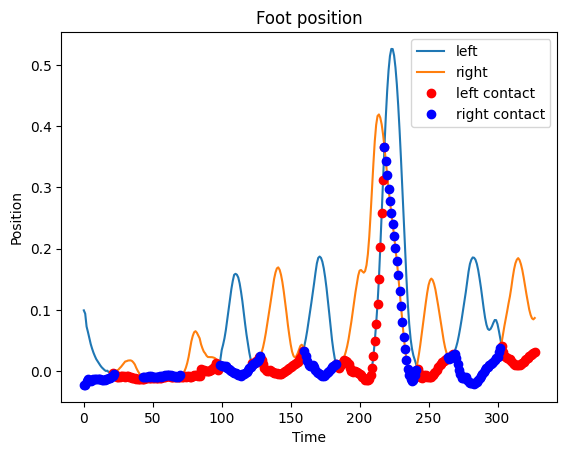

In [32]:
x = np.arange(0, len(left_z))
x_left = x[left_food_contact == 1]
x_right = x[right_food_contact == 1]

plt.plot(x, corrected_left_z, label='left')
plt.plot(x, corrected_right_z, label='right')
plt.plot(x_left, corrected_left_z[left_food_contact == 1], 'ro', label='left contact')
plt.plot(x_right, corrected_right_z[right_food_contact == 1], 'bo', label='right contact')

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Foot position')
plt.legend()

plt.show()

In [446]:
left_food_contact

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [447]:
right_food_contact

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [432]:
def label_contact(left_ankle_poses, right_ankle_poses, threshold = 0.002):
    
    left_z = left_ankle_poses[:,2]
    right_z = right_ankle_poses[:,2]

    left_flat_positions = find_flat_segments(left_z)
    right_flat_positions = find_flat_segments(right_z)

    mean_left_z = np.mean(left_z[left_flat_positions])
    corrected_left_z = left_z - mean_left_z 

    mean_right_z = np.mean(right_z[right_flat_positions])
    corrected_right_z = right_z - mean_right_z

    left_foot_contact = np.zeros_like(left_z)
    right_foot_contact = np.zeros_like(right_z)

    diff = corrected_left_z - corrected_right_z
    left_foot_contact[np.abs(diff) < threshold] = 1
    right_foot_contact[np.abs(diff) < threshold] = 1

    left_foot_contact[diff >= threshold] = 0
    right_foot_contact[diff >= threshold] = 1

    left_foot_contact[diff <= -threshold] = 1
    right_foot_contact[diff <= -threshold] = 0

    return left_foot_contact, right_foot_contact

In [433]:
left_foot_contact, right_foot_contact = label_contact(left_ankle_poses, right_ankle_poses)

In [434]:
left_foot_contact

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [435]:
right_foot_contact

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [66]:
root_pos = adam_pose["new_root_poses"]
root_rot = adam_pose["root_rot"]
root_vel = adam_pose["root_vel"]
root_angular_vel = adam_pose["root_angular_vel"]
dof_pos = adam_pose["dof_pos"]
dof_vel = adam_pose["dof_vel"]

frame_num = len(root_pos)

root_states = torch.cat([torch.from_numpy(root_pos), torch.from_numpy(root_rot), torch.from_numpy(root_vel), torch.from_numpy(root_angular_vel)], dim=1).type(torch.float32)
dof_states = torch.stack([torch.from_numpy(dof_pos), torch.from_numpy(dof_vel)],axis=2).type(torch.float32)
rigid_body_states = []

# Simulate
new_root_poses = []

for i in range(frame_num):

    gym.set_actor_root_state_tensor(sim, gymtorch.unwrap_tensor(root_states[i]))
    gym.set_dof_state_tensor(sim, gymtorch.unwrap_tensor(dof_states[i]))
    gym.refresh_rigid_body_state_tensor(sim)
    rigid_body_state = gym.acquire_rigid_body_state_tensor(sim)
    rigid_body_state = gymtorch.wrap_tensor(rigid_body_state)
    left_foot_poses = rigid_body_state[left_foot_indices, 0:3]
    right_foot_poses = rigid_body_state[right_foot_indices, 0:3]
    print(torch.min(torch.cat([left_foot_poses, right_foot_poses])[:,2]))

tensor(-6.7055e-08)
tensor(7.4506e-09)
tensor(7.4506e-09)
tensor(1.4901e-08)
tensor(-7.4506e-09)
tensor(-2.2352e-08)
tensor(-2.9802e-08)
tensor(-8.1956e-08)
tensor(-7.4506e-09)
tensor(2.2352e-08)
tensor(-7.4506e-09)
tensor(1.4901e-08)
tensor(-2.2352e-08)
tensor(-1.4901e-08)
tensor(2.2352e-08)
tensor(-1.4901e-08)
tensor(-7.4506e-09)
tensor(-5.2154e-08)
tensor(-3.7253e-08)
tensor(5.2154e-08)
tensor(0.)
tensor(0.)
tensor(-7.4506e-09)
tensor(0.)
tensor(-2.9802e-08)
tensor(-1.4901e-08)
tensor(7.4506e-09)
tensor(4.4703e-08)
tensor(0.)
tensor(7.4506e-09)
tensor(-7.4506e-09)
tensor(2.2352e-08)
tensor(-2.2352e-08)
tensor(2.2352e-08)
tensor(8.1956e-08)
tensor(2.2352e-08)
tensor(7.4506e-09)
tensor(-3.7253e-08)
tensor(-1.4901e-08)
tensor(-1.4901e-08)
tensor(-1.4901e-08)
tensor(-7.4506e-09)
tensor(1.4901e-08)
tensor(1.4901e-08)
tensor(2.9802e-08)
tensor(-3.7253e-08)
tensor(1.4901e-08)
tensor(-8.1956e-08)
tensor(2.2352e-08)
tensor(7.4506e-09)
tensor(-2.2352e-08)
tensor(-7.4506e-09)
tensor(-7.4506e-0

In [451]:
adam_poses = joblib.load("/home/jianrenw/MAP/data/isaac_adam_standard_walk.pt")
key = 'BioMotionLab_NTroje_rub032_0027_circle_walk_poses'
adam_pose = adam_poses[key]

root_pos = adam_pose["root_pos"]
root_rot = adam_pose["root_rot"]
root_vel = adam_pose["root_vel"]
root_angular_vel = adam_pose["root_angular_vel"]
dof_pos = adam_pose["dof_pos"]
dof_vel = adam_pose["dof_vel"]
body_pos = adam_pose["body_pos"]
left_foot_contact = adam_pose["left_foot_contact"]
right_foot_contact = adam_pose["right_foot_contact"]
dt = adam_pose["dt"] 


In [452]:
left_foot_contact

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [453]:
right_foot_contact

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [407]:
rigid_body_state[rigid_body_names.index('toeLeft')]

tensor([-5.8685e-01,  1.4845e-01,  7.9206e-02,  1.4441e-02, -2.1077e-02,
         9.9240e-01, -1.2040e-01,  1.1560e-04, -1.0616e-04, -1.2174e-05,
        -6.4688e-04,  6.9496e-04,  1.7873e-03])